# Reinforcement Learning, Part 1: Agents, States, and Rewards  

Here we will show the simplest form of RL: An agent going through a simple environment with a determinstic succession of states.

## The environment

The environment represents a prototypical conditing paradigm. It is made of three states, which represent an initial  cue, a delay, and a reward. This captures a simple experiment such as the case in which a primate is given reward (juice) after a blue light is presented.

An environment is defined by two functions, the state transition matrix $P(s,a,s')$ and a reward transition matrix $R(s,a,s')$. In this simple case, the agent does not act---it is simply observing the environment. So, we can define $P(s,s')$ and $R(s,s')$ without any reference to any action $a$. Furthermore, because the environment is deterministic, we can represent both $P(s,s')$ and $R(s,s')$ as _tables_.

### Implementation in Python

In the code below, the Environment's state and reward transitions are implemented as _dictionaries_, that is, special structures that associate one object (the _key_) with another (the _value_). This is a vary convenient format for a simple environments in which all events follow deterministically. THe `STATE_TRANSITIONS` dictionary links each state with the state that follows. The `REWARD_TRANSITIONS` dictionary links each state with its associated reward.  The null object `None` marks the end of a trial.

When the environment undergoes a transition, the agent receives a new state-reward pair, which, in Python, will be represented as a tuple `(new_state, new_reward)`.

In [81]:
import matplotlib.pyplot as plt 
import random

class Environment:
    """A simple environment"""
    STATE_TRANSITIONS = {"cue" : "wait",
                         "wait" : "juice",
                         "juice" : None}
    
    REWARD_TRANSITIONS = {"cue" : 0,
                          "wait" : 0,
                          "juice" : 1,
                          None : 0}
    
    def __init__(self):
        """Initializes the environment"""
        # An environment class always keeps track of the current state we are in.
        # We always begin with the state 'cue' (the beginning of a trial)
        self.state = "cue"
    
    
    def transition(self):
        """Transitions, and returns the state-reward pair"""
        state = self.state  # The current state
        
        if state.startswith("start"):
            new_state = "cue"
        else:
            new_state = Environment.STATE_TRANSITIONS[state]
        new_reward = Environment.REWARD_TRANSITIONS[new_state]
        
        # Let's update the current state before 
        self.state = new_state
        
        # The agent receives the new state and reward. 
        return (new_state, new_reward)

### Testing the environment

Let's test the environment works

In [63]:
e = Environment()
print("State 1: '%s'" % (e.state,))

# First transition: Cue -> Wait
res = e.transition()
print("State 2: '%s', Reward = %s" % res)

# Second transition: Wait -> Juice
res = e.transition()
print("State 3: '%s', Reward = %s" % res)

# Final transition: Juice -> 'None'
res = e.transition()
print("After state 3: '%s'" % (e.state,))


State 1: 'cue'
State 2: 'wait', Reward = 0
State 3: 'juice', Reward = 1
After state 3: 'None'


## The Agent

Now, let's create a simple agent that just observes states and estimates their values by creating a $V$-table. Because the number of states is so small, the $V$-table can be initialized right away, with all the states being zero. 

The $V$-Agent learns the value of states using TD-learning. Every time the agent observes a new state, it updates the associated value of the previous state using the TD-learning equation:

$V(S_t) = V(S_t) + \alpha [ r_{t} + \gamma V(S_{t+1}) - V(S_t)]$

### Implementation in Python

The agent is an object with two internal parameters, `alpha` and `gamma` (which record to the $\alpha$ and $\gamma$ values of the TD-learning equation), and a dictionary that records the $V$-values associated with every state (The $V$ table). The agent has a single method, `learn`, tha implements the TD-learning equation.

In [74]:
class TDAgent():
    """An agent that passively observes states"""
    def __init__(self, gamma=0.9, alpha=0.1):
        "Initializes an agent with default parameters and zero values in the V table"
        self.V = {"cue" : 0,
                  "wait" : 0,
                  "juice" : 0,
                  None : 0}
        
        self.RPE = {"cue" : 0,
                    "wait" : 0,
                    "juice" : 0,
                     None : 0}
        self.gamma = gamma
        
        self.alpha = alpha
        
    # This method implements TD-learning
    #
    def TD_learn(self, state1, reward1, state2):
        """Learns using TD-learning"""
        V1 = self.V[state1] if state1 in self.V.keys() else 0
        V2 = self.V[state2]
        g = self.gamma
        a = self.alpha
        
        # Calculate RPE and new estimate of V1
        rpe = reward1 + g * V2 - V1
        V1 = V1 + a * rpe
        
        # Save the RPEs for demo
        if state2 is None:
            self.RPE["juice"] = rpe
        else:
            self.RPE[state2] = rpe
        
        # Update the internal value of V1
        self.V[state1] = V1

## Interactions between agent and environment
Now, we need to define how to run a trial. 

In [65]:
def rl_loop(environment, agent):
    "The interaction cycle between an agent and its environment"
    while environment.state is not None:
        state = environment.state
        if state.startswith("start"):
            reward = 0
        else:
            reward = environment.REWARD_TRANSITIONS[state]
        
        # This is the moment in which we learn!
        transition = environment.transition()
        new_state = None
        if transition is not None:
            new_state = transition[0]
        
        agent.TD_learn(state, reward, new_state)

        
def run_trials(environment, agent, n):
    "Run multiple simulations within an environment"
    for j in range(n):
        environment.state = "start%d" % (random.randint(0, 1000))
        rl_loop(environment, agent)   

## Testing the system

To test the system, we need to create a function that visualizes a $V$-table. The following function takes the an agent's dictionary of state-value associations and visualizes them ina bargraph. For simplicity, the state `None` is not shown 

In [78]:
# This is a simple function to visualize the agent's V-table
def plot_v_table(Vtable, axes, title="V table"):
    """Visualizes the V-table"""
    states = ["cue", "wait", "juice"]
    values = [Vtable[x] for x in states]

    axes.axis([-0.5, 2.5, 0, 1.0])
    axes.set_xticks([0, 1, 2])
    axes.set_xticklabels(["bell", "wait", "food!"])
    axes.bar([0, 1, 2], values)
    axes.set_title(title)
    
def plot_rpes(rpes, axes, title="V table"):
    """Visualizes the V-table"""
    states = ["cue", "wait", "juice"]
    values = [rpes[x] for x in states]
    
    axes.axis([-0.5, 2.5, 0, 1.0])
    axes.set_xticks([0, 1, 2])
    axes.set_xticklabels(["cue", "wait", "juice"])
    axes.bar([0, 1, 2], values)
    axes.set_title(title)

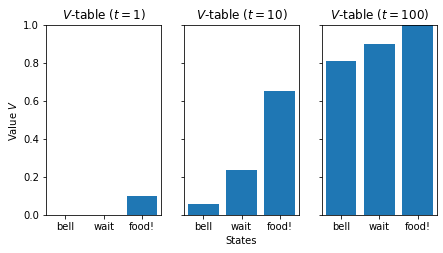

In [80]:
states = ["cue", "wait", "juice", None]

a = TDAgent()
e = Environment()

fig, axs = plt.subplots(1,3, figsize=(7,3.5), sharey=True)

for ax in axs.flat:
    ax.label_outer()

axs[0].set_ylabel(r"Value $V$")
axs[1].set_xlabel("States")    

run_trials(e, a, 1)
plot_v_table(a.V, axs[0], r"$V$-table ($t=1$)")

run_trials(e, a, 9)
plot_v_table(a.V, axs[1], r"$V$-table ($t=10$)")

run_trials(e, a, 90)
plot_v_table(a.V, axs[2], r"$V$-table ($t=100$)")

plt.savefig("figures/vtable.png")

Now, we can test the agent's learning by visualizing its internal $V$-table at different momements during learning.

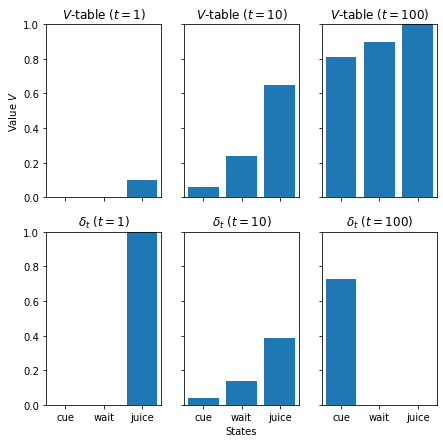

In [79]:
states = ["cue", "wait", "juice", None]

a = TDAgent()
e = Environment()

fig, axs = plt.subplots(2,3, figsize=(7,7), sharey=True)

for ax in axs.flat:
    ax.label_outer()

axs[0,0].set_ylabel(r"Value $V$")
axs[1,1].set_xlabel("States")    

run_trials(e, a, 1)
plot_v_table(a.V, axs[0, 0], r"$V$-table ($t=1$)")
plot_rpes(a.RPE, axs[1, 0], r"$\delta_t$ ($t=1$)")

run_trials(e, a, 9)
plot_v_table(a.V, axs[0, 1], r"$V$-table ($t=10$)")
plot_rpes(a.RPE, axs[1, 1], r"$\delta_t$ ($t=10$)")

run_trials(e, a, 90)
plot_v_table(a.V, axs[0, 2], r"$V$-table ($t=100$)")
plot_rpes(a.RPE, axs[1, 2], r"$\delta_t$ ($t=100$)")

plt.savefig("figures/vtable_rpe.png")

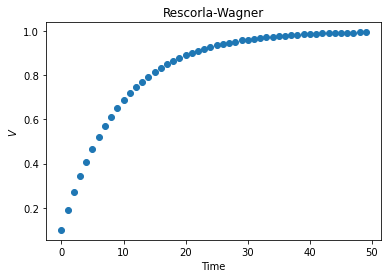

In [91]:
V = 0
alpha = 0.1
R = 1

Vs = []
for t in range(50):
    dV = alpha * (R - V)
    V += dV
    Vs.append(V)

plt.plot(Vs, "o")
plt.title("Rescorla-Wagner")
plt.xlabel("Time")
plt.ylabel(r"$V$")
plt.savefig("figures/r-w.png")

In [68]:
print(a.RPE)

{'cue': 0.0014316594000409744, 'wait': 0.0002921753877633826, 'juice': 2.9512665430719842e-05, None: 0}
